# 5. Transformer recipe generator training

Note: This notebook is desinged to run with GPU runtime.

Install Huggingface libraries to use the pretrained tokenizer.

In [ ]:
pip install -q git+https://github.com/huggingface/transformers.git datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Install Google Translate library to convert generated texts to other languages.

In [ ]:
pip install -q googletrans==4.0.0-rc1

Import modules and set random seeds.

In [ ]:
import os, random
os.environ['PYTHONHASHSEED'] = str(20230629)
random.seed(20240329)

import matplotlib.pyplot as plt
import numpy as np
from pandas import DataFrame

import tensorflow as tf
from tensorflow.keras import layers, models
from googletrans import Translator

np.random.seed(20230629)
tf.random.set_seed(20230629)

plt.rcParams.update({'font.size': 10})

Download the pretrained tokenizer and check the vacabulary size.

In [ ]:
from transformers import AutoTokenizer, AutoConfig
model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
VOCAB_SIZE = AutoConfig.from_pretrained(model_ckpt).vocab_size

print('Vocabulary size: {}'.format(VOCAB_SIZE))

Vocabulary size: 30522


Mount the google drive and load the trained model.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

transformer_model = models.load_model('/content/gdrive/My Drive/Transformer_recipe_generator')
attention_scores_model = models.load_model('/content/gdrive/My Drive/Transformer_recipe_generator_attention_scores')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Define a function to generate new texts.

In [ ]:
def sample_from(probs, temp):
    probs = probs ** (1 / temp)
    probs = probs / np.sum(probs)
    return np.random.choice(len(probs), p=probs), probs


def gen_text(prompt, temp=0.1, lang='en'):
    tokenized_text = tokenizer(prompt)
    input_ids = np.array(tokenized_text['input_ids'])[:-1]

    for i in range(256):
        if i % 100 == 0 and i > 0:
            print('')
        probs = transformer_model.predict(np.array([input_ids]), verbose=0)[0][-1]
        next_token, _ = sample_from(probs, temp)
        next_word = tokenizer.convert_ids_to_tokens([next_token])[0]
        if next_word == '[SEP]':
            break
        print('.', end='')
        input_ids = np.append(input_ids, next_token)

    answer = tokenizer.convert_tokens_to_string(
        tokenizer.convert_ids_to_tokens(input_ids[1:])
    )
    print('')

    if lang == 'en':
        return answer, answer

    translator = Translator()
    translated = translator.translate(answer, dest=lang);
    return answer, translated.text

Define a function to show top 10 tokens following the input text.

In [ ]:
def top_k(prompt, temp=0.1):
    tokenized_text = tokenizer(prompt)
    input_ids = np.array(tokenized_text['input_ids'])[:-1]

    probs = transformer_model.predict(np.array([input_ids]), verbose=0)[0][-1]
    _, probs = sample_from(probs, temp)
    probs = list(zip(probs, range(len(probs))))
    top_k = sorted(probs, reverse=True)[:10]
    probs = [p for p, _ in top_k]
    labels = [tokenizer.convert_ids_to_tokens([token])[0] for _, token in top_k]

    n = len(probs)
    fig = plt.figure(figsize=(6, 2))
    subplot = fig.add_subplot(1, 1, 1)
    subplot.set_xticks(range(n))
    subplot.set_xlim([-0.5, n - 0.5])
    subplot.set_ylim([0, 1])
    subplot.set_xticklabels(labels)
    subplot.set_title(prompt, fontsize=11)
    _ = subplot.bar(range(n), probs, align='center')

Generate some sample texts.

In [ ]:
gen_text('Recipe for beef', temp=1.0, lang='ja')

....................................................................................................
..........................................


('recipe for beef sandwichlla with potatoes : preheat oven to 350 degrees f ( 175 degrees c ). spray baking sheet with oil. heat 1 tablespoon olive oil in a skillet over medium - high heat and stir onion and garlic in the hot oil until browned and no longer transparent, squeeze off any excess. remove potatoes from skillet and mash in the hot oil. in a bowl, cook the bacon and stir beef aside. the onion, onion, mushrooms, and cook 3 to 4 minutes, stirring occasionally to cook until tender. drain onion mixture into the skillet and continue cooking until garlic is browned and evenly brown, about 5 minutes more minutes. after the potatoes, tomatoes are tender.',
 'ジャガイモとビーフサンドイッチラのレシピ：オーブンを350度F（175度C）に予熱します。天板をオイルでスプレーします。ミディアムの上でフライパンで大さじ1杯のオリーブオイルを加熱します - 強火とタマネギとニンニクとニンニクを熱いオイルで茶色にして透明にしなくなるまで、余分なものを絞ります。ジャガイモをフライパンから取り除き、熱い油をマッシュします。ボウルで、ベーコンを調理し、牛肉をかき混ぜます。タマネギ、タマネギ、マッシュルーム、調理、3〜4分、柔らかくなるまで調理するために時々かき混ぜます。オニオンの混合物をフライパンに排出し、ニンニクが茶色になり、均等に茶色になるまで、さらに約5分の茶色になるまで調理を続けます。ジャガイモの後、トマトは柔らかいで

In [ ]:
gen_text('Recipe for beef', temp=0.5, lang='ja')

....................................................................................................
..............................................


('recipe for beef and mushroom soup : heat the olive oil in a large pot over medium heat. add the onion, garlic, and cook until soft, about 5 minutes. stir in the tomatoes, tomato paste, garlic, and cook until vegetables are tender, about 5 minutes. add the garlic, salt, and pepper ; cook until onion has softened, about 5 minutes. add the tomatoes, tomato sauce, garlic, salt, and pepper ; cook until tomatoes are soft, about 5 minutes. stir in tomatoes, tomato paste, salt, oregano, and red pepper flakes. simmer until flavors are fork - pink inside, about 5 minutes. stir in tomatoes, and simmer for 5 minutes. season with salt and pepper to taste.',
 '牛肉とキノコのスープのレシピ：オリーブオイルを大きな鍋で中火で加熱します。タマネギ、ニンニクを加え、柔らかくなるまで約5分間調理します。トマト、トマトペースト、ニンニクをかき混ぜ、野菜が柔らかくなるまで約5分間調理します。ニンニク、塩、コショウを加えます。タマネギが柔らかくなるまで、約5分間調理します。トマト、トマトソース、ニンニク、塩、コショウを加えます。トマトが柔らかくなるまで約5分間調理します。トマト、トマトペースト、塩、オレガノ、赤唐辛子のフレークをかき混ぜます。フレーバーがフォークになるまで煮る - 中はピンク、約5分。トマトをかき混ぜ、5分間煮る。塩とコショウで味付けして味付けします。')

In [ ]:
gen_text('Recipe for beef', temp=0.1, lang='ja')

....................................................................................................
................


('recipe for beef and mushroom soup : heat the oil in a large pot over medium heat. add the onion, garlic, and cook until onion is softened, about 5 minutes. stir in the onion, and cook until onion is translucent, about 5 minutes. stir in the tomato sauce, tomato sauce, and cook until vegetables are tender, about 5 minutes. stir in the tomatoes, tomato sauce, tomato sauce, tomato sauce, tomato sauce, and tomato sauce. simmer for 5 minutes. stir in the tomatoes, tomato sauce, tomato sauce, and tomato sauce. season with salt and pepper.',
 '牛肉とマッシュルームのスープのレシピ：中火で大きな鍋で油を加熱します。タマネギ、ニンニクを加え、タマネギが柔らかくなるまで約5分間調理します。タマネギをかき混ぜ、タマネギが半透明になるまで約5分間調理します。トマトソース、トマトソースをかき混ぜ、野菜が柔らかくなるまで約5分間調理します。トマト、トマトソース、トマトソース、トマトソース、トマトソース、トマトソースをかき混ぜます。5分間煮る。トマト、トマトソース、トマトソース、トマトソースをかき混ぜます。塩とコショウで味付けします。')

In [ ]:
gen_text('Recipe for apple', temp=1.0, lang='ja')

..............................................................................


('recipe for apple pie : preheat oven to 375 degrees f ( 190 degrees c ). place rhubarb in a medium baking dish, mix together apple cider croutons, sugar, eggs, eggs, applesauce, butter and egg until pecan topping is well blended. bake in preheated oven until a knife inserted into center comes out clean, about 50 minutes.',
 'Apple Pieのレシピ：オーブンを375度F（190度C）に予熱します。ラバーブを中程度のベーキング皿に入れ、アップルサイダークルトン、砂糖、卵、卵、アップルソース、バター、卵を混ぜ合わせて、ピーカンのトッピングがよく混ざります。中央に挿入されたナイフがきれいになるまで、予熱したオーブンで焼きます。約50分です。')

In [ ]:
gen_text('Recipe for apple', temp=0.5, lang='ja')

...................................................................................................


('recipe for apple chicken : preheat oven to 350 degrees f ( 175 degrees c ). grease an 8x8 inch baking dish. combine the flour, salt, and 1 / 2 teaspoon cinnamon in a bowl. whisk milk, egg, vegetable oil, and egg together in a large bowl. add chicken broth, and stir until combined. pour into prepared baking dish. bake in the preheated oven until chicken is no longer pink in the center, about 45 minutes.',
 'アップルチキンのレシピ：オーブンを350度F（175度C）に予熱します。8x8インチのベーキング皿にグリースを塗ります。小麦粉、塩、小さじ1 /2のシナモンをボウルに混ぜます。牛乳、卵、植物油、卵を大きなボウルに入れて泡立てます。チキンスープを加え、結合するまでかき混ぜます。準備したベーキング皿に注ぎます。鶏肉が中央でピンク色にならなくなるまで、約45分間、予熱したオーブンで焼きます。')

In [ ]:
gen_text('Recipe for apple', temp=0.1, lang='ja')

....................................................................................................
.......................


('recipe for apple pie : preheat oven to 350 degrees f ( 175 degrees c ). grease a 9x13 inch baking dish. combine rhubarb, 1 / 2 cup sugar, and 1 / 2 teaspoon cinnamon in a bowl. mix together flour, 1 / 2 cup sugar, and 1 / 2 teaspoon cinnamon. stir in rhubarb. pour rhubarb mixture over rhubarb mixture. bake in preheated oven until a knife inserted into center comes out clean, about 50 minutes. cool in pan for 10 minutes. remove from oven and cool completely.',
 'アップルパイのレシピ：オーブンを350度F（175度C）に予熱します。9x13インチのベーキング皿にグリースを塗ります。ボウルにルバーブ、1/2カップの砂糖、小さじ1/2のシナモンを混ぜます。小麦粉、1/2カップの砂糖、小さじ1 /2のシナモンを混ぜます。ルバーブをかき混ぜます。ルバーブ混合物にルバーブ混合物を注ぎます。中央に挿入されたナイフがきれいになるまで、予熱したオーブンで焼きます。約50分です。パンで10分間冷やします。オーブンから取り出し、完全に冷まします。')

Show top 10 tokens for a sample text.

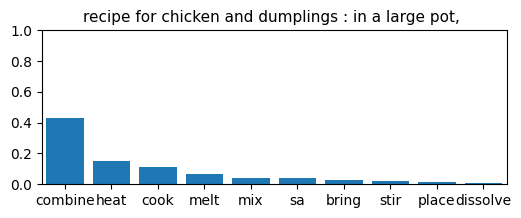

In [ ]:
top_k('recipe for chicken and dumplings : in a large pot, ', temp=1.0)

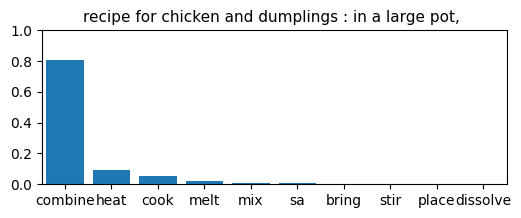

In [ ]:
top_k('recipe for chicken and dumplings : in a large pot, ', temp=0.5)

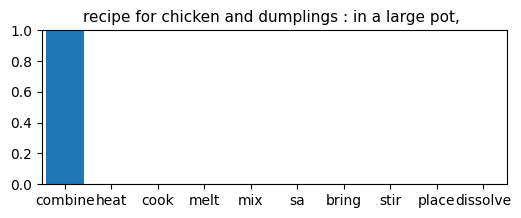

In [ ]:
top_k('recipe for chicken and dumplings : in a large pot, ', temp=0.1)

Show attention weights (averaged over multiple attention heads) for the Transformer encoder layers.

In [ ]:
prompts = [
    'recipe for chicken steak : in a large bowl, combine the chicken, onion,',
    'recipe for chicken breasts : mix the garlic powder in a small bowl.',
    'in a small bowl. stir vegetable soup and mix in chicken',
]

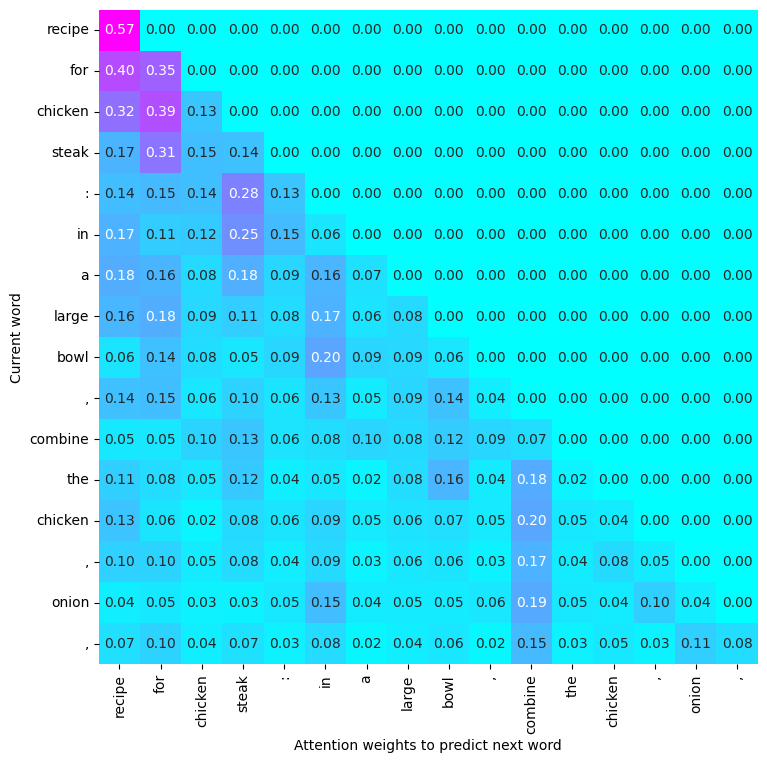

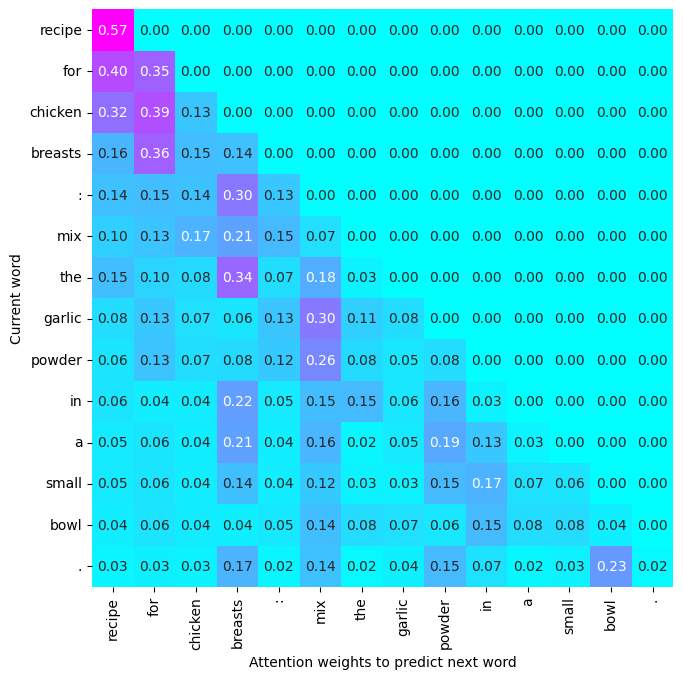

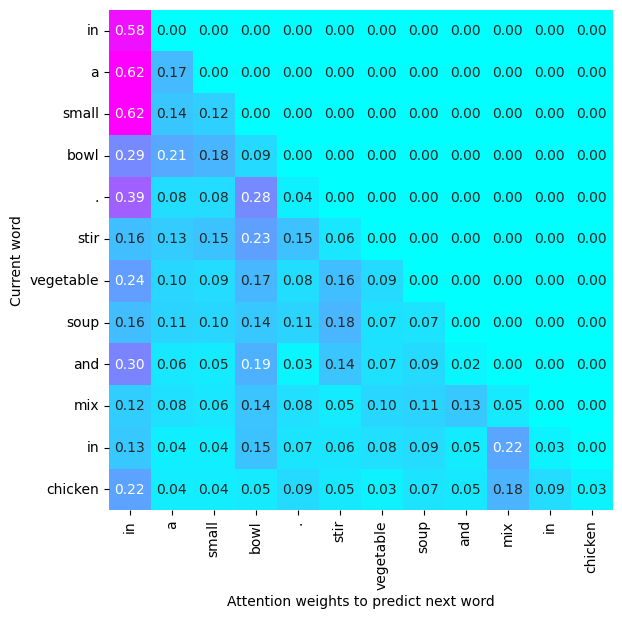

In [ ]:
import seaborn as sns

for prompt in prompts:
    tokenized_text = tokenizer(prompt)
    input_ids = np.array(tokenized_text['input_ids'])[:-1]
    _, attention_scores = attention_scores_model.predict(np.array([input_ids]), verbose=0)
    labels = tokenizer.convert_ids_to_tokens(input_ids)
    text_len = attention_scores.shape[-1]

    fig = plt.figure(figsize=(text_len/2, text_len/2))
    subplot = fig.add_subplot(1, 1, 1)
    heatmap = sns.heatmap(np.mean(attention_scores[0, :, 1:text_len, 1:text_len], axis=0),
                    ax = subplot,
                    xticklabels=labels[1:text_len], yticklabels=labels[1:text_len],
                    cmap='cool', cbar=False, annot=True, fmt='1.2f')
    _ = heatmap.set(xlabel='Attention weights to predict next word', ylabel='Current word')